In [43]:
pd.options.mode.chained_assignment = None
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import math
from adjustText import adjust_text

sns.set(rc={'figure.figsize':(20, 30)})

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
%matplotlib inline
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pyperclip as pc

# Load files 

In [2]:
eae_genes = pd.read_csv('data\EAE_gene_list.csv')
ms_genes = pd.read_csv('data\MS_related_genes.csv')
df=pd.read_excel('data\\Unstim_vs_IgE_Differential_Expression.xlsx')

# Preprocess and log transform

In [3]:
def preprocess(df):
    df = df[['Gene Symbol', 'Entrez ID', 'F_unstim_S4', 'M_unstim_S2', 'F_IgE_S3', 'M_IgE_S1']]
    df = df.dropna()
    df = df.replace(0, np.nan)
    df = df.dropna(axis=0, thresh = 4).fillna(0)
    return df
def logs(i):
    i["log_Mi"] = np.log2(i['M_IgE_S1']+1)
    i["log_Fi"] = np.log2(i['F_IgE_S3']+1)
    i["log_Mu"] = np.log2(i['M_unstim_S2']+1)
    i["log_Fu"] = np.log2(i['F_unstim_S4']+1)
    i["unstim_XD"] = i["log_Mu"] - i["log_Fu"]
    i["IgE_XD"] = i["log_Mi"] - i["log_Fi"]
    return i

In [4]:
df = preprocess(df)
df = logs(df)

In [5]:
df.head()
df.shape

,Gene Symbol,Entrez ID,F_unstim_S4,M_unstim_S2,F_IgE_S3,M_IgE_S1,log_Mi,log_Fi,log_Mu,log_Fu,unstim_XD,IgE_XD
0,Ccl1,20290,4.829065,4.680695,23959.367737,43864.638069,15.420804,14.548362,2.506067,2.543265,-0.037197,0.872441
1,Serpinb9b,20706,0.804844,2.340347,12956.022455,9704.409675,13.244573,13.661447,1.739998,0.851874,0.888124,-0.416873
2,Gstt1,14871,17.706573,7.021042,2446.966235,3081.395634,11.589836,11.257368,3.003790,4.225473,-1.221684,0.332468
3,Il9,16198,0.000000,0.000000,3954.312500,3016.280182,11.559033,11.949576,0.000000,0.000000,0.000000,-0.390543
4,Slco5a1,240726,15.292041,15.212258,1585.491012,1378.461013,10.429889,10.631624,4.019013,4.026095,-0.007082,-0.201735


(14445, 12)

In [14]:
def sexdominant(df):
    if (df['IgE_XD'] > 0):
        return "M"
    if (df['IgE_XD'] < 0):
        return "F"

def heatmapper(df):
    df['IgE dominance'] = df.apply(sexdominant, axis=1)
    df = df[['Gene Symbol', 'log_Fu', 'log_Mu', 'log_Fi', 'log_Mi', 'IgE dominance']].set_index('Gene Symbol')
    lut = {"M":"blue", "F":"red"}
    row_colors =df['IgE dominance'].map(lut)
    
    fig = sns.clustermap(data=df[['log_Fu', 'log_Mu', 'log_Fi', 'log_Mi']], 
               z_score=0,
               metric = 'correlation',
               row_cluster=True, 
               col_cluster=False, 
               cmap='coolwarm',
               figsize=(10, 15),
               cbar_pos=(.1, .81, .05, .1),
               row_colors=row_colors)
    return fig

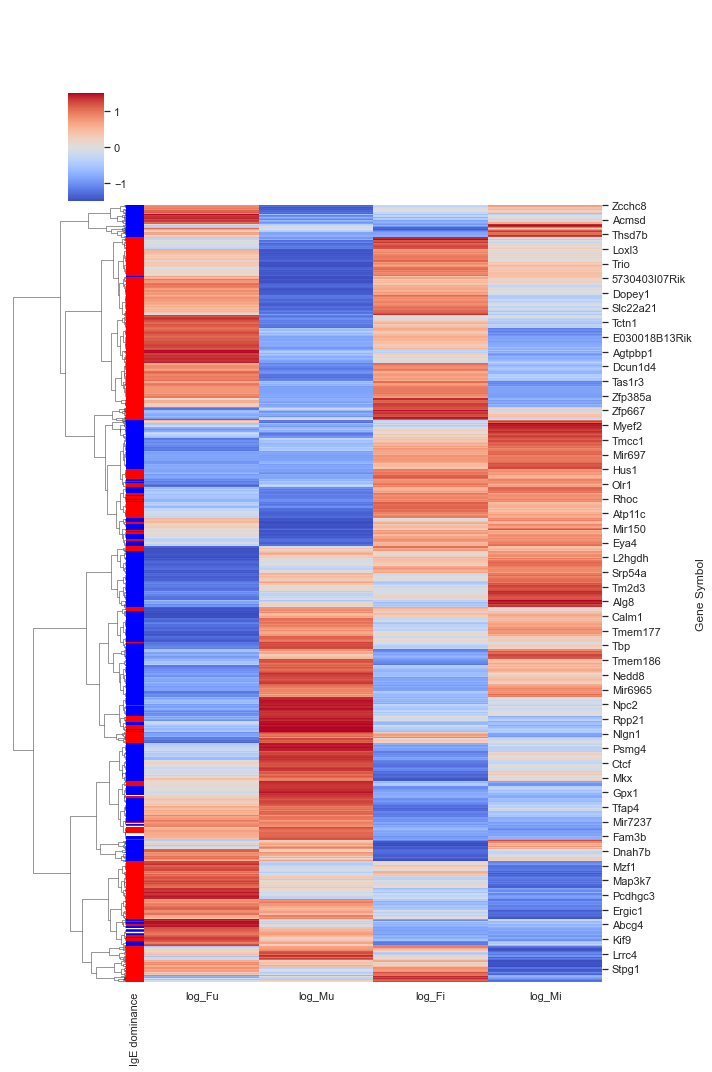

In [15]:
heatmapper(df);

In [18]:
df['IgE dominance'].value_counts()

M    7338
F    6947
Name: IgE dominance, dtype: int64

In [48]:
def ontolist(df, sex='M'):
    a=''
    if sex=='M':
        for i in df.loc[df['IgE dominance']=='M']['Gene Symbol'].tolist():
            a+= i + '\n'
    else:
        for i in df.loc[df['IgE dominance']=='F']['Gene Symbol'].tolist():
            a+= i + '\n'
    return pc.copy(a)

In [54]:
ontolist(df2, 'F')

# exploration

# output fn and sex difference filter

In [36]:
def outputting(df, name='', date= '220328'):
    df = df[['Gene Symbol', 'log_Fu', 'log_Mu', 'log_Fi', 'log_Mi']]
    df.columns = ['NAME', 'F_unstim', 'M_unstim', 'F_IgE', 'M_IgE']
    df.to_csv("outputs//"+date+" "+name+".csv", index=False)
    return

def sexdiff(df, thresh=0.58):
    nthresh = -1 * thresh
    
    # "Stimulated sexdif > threshold" OR "stimulated sexdif < -threshold"
    df = df.loc[(df["IgE_XD"] > thresh) | (df["IgE_XD"] < nthresh)]# |  (df["unstim_XD"] > thresh) |  (df["unstim_XD"] < nthresh)]
   
    print(df.shape)
    return df

In [28]:
sexdiff(df, 2).head()

(1559, 13)


,Gene Symbol,Entrez ID,F_unstim_S4,M_unstim_S2,F_IgE_S3,M_IgE_S1,log_Mi,log_Fi,log_Mu,log_Fu,unstim_XD,IgE_XD,IgE dominance
40,Ccl3,20302,87.728022,444.665991,64445.878718,52441.115675,15.678438,15.975823,8.799819,6.471318,2.328501,-0.297385,F
72,Trib1,211770,0.000000,3.510521,204.306146,178.791581,7.490182,7.681633,2.173294,0.000000,2.173294,-0.191451,F
132,Tigit,100043314,0.000000,4.680695,145.932961,134.645511,7.083697,7.199014,2.506067,0.000000,2.506067,-0.115317,F
149,Ndnf,68169,14.487196,4.680695,914.199390,195.346356,7.617257,9.837942,2.506067,3.953004,-1.446937,-2.220685,F
150,Sema7a,20361,32.998614,5.850868,901.959851,432.631479,8.760326,9.818518,2.776287,5.087404,-2.311117,-1.058192,F


In [29]:
df2 = sexdiff(df)

(9866, 13)


C:\Users\H\anaconda3\lib\site-packages\seaborn\matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


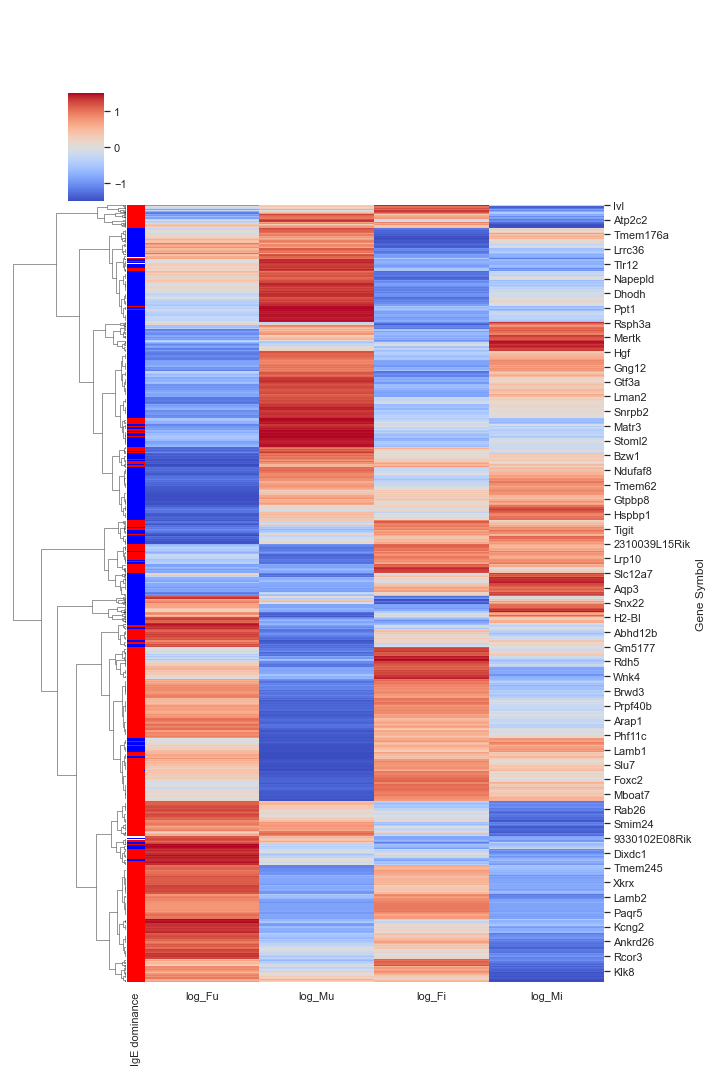

In [30]:
heatmapper(df2)

In [31]:
df2['IgE dominance'].value_counts()

F    5263
M    4530
Name: IgE dominance, dtype: int64

In [40]:
ontolist(df1, "M")

NameError: name 'pc' is not defined

# EAE related genes

In [37]:
all_eae_df = df.loc[df['Entrez ID'].isin(eae_genes['GeneID'])]
#outputting(all_eae_df, '0328 eae genes')
eae_df = df1.loc[df1['Gene Symbol'].isin(eae_genes['Symbol'])]
eae_df_2 = df2.loc[df2['Gene Symbol'].isin(eae_genes['Symbol'])]
#outputting(eae_df, '0328 eae genes sexbiased')

In [38]:
all_eae_df['IgE dominance'].value_counts()
eae_df['IgE dominance'].value_counts()
eae_df_2['IgE dominance'].value_counts()

M    151
F    139
Name: IgE dominance, dtype: int64

M    82
F    70
Name: IgE dominance, dtype: int64

M    114
F    111
Name: IgE dominance, dtype: int64

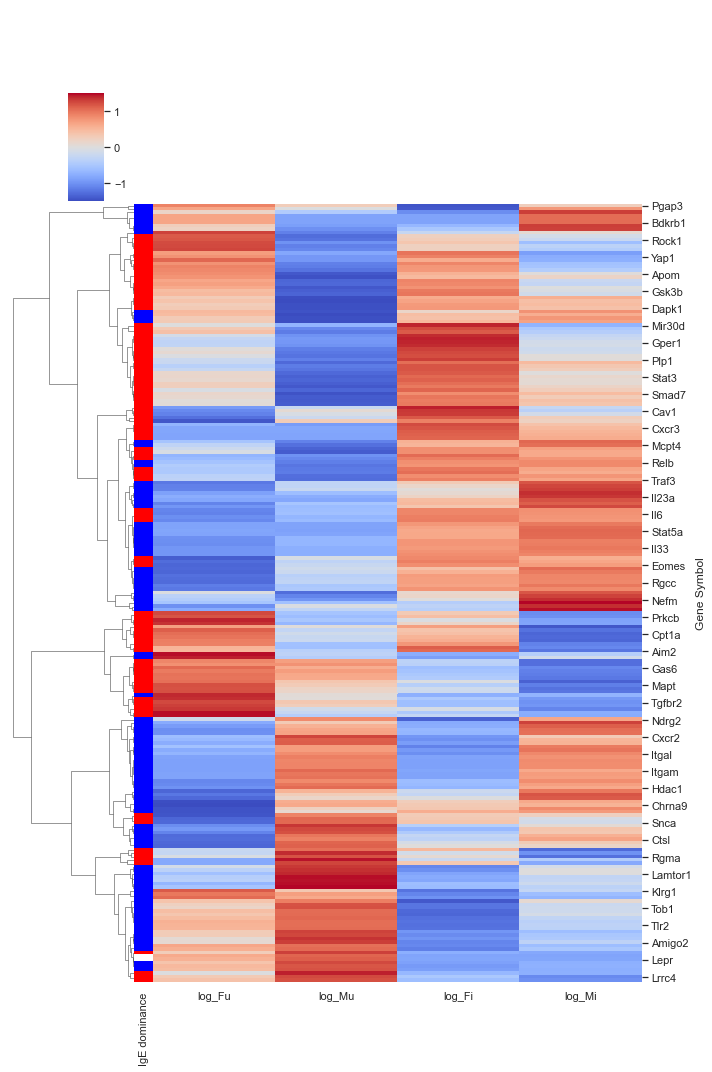

In [39]:
heatmapper(eae_df_2)

In [60]:
ontolist(eae_df_2, 'F')

In [48]:
eae_df.head()

,Gene Symbol,Entrez ID,F_unstim_S4,M_unstim_S2,F_IgE_S3,M_IgE_S1,log_Mi,log_Fi,log_Mu,log_Fu,unstim_XD,IgE_XD,IgE dominance
9,Csf2,12981,12.877508,42.126252,9607.096369,5889.085639,12.524073,13.230035,5.430494,3.794677,1.635818,-0.705962,-1
14,Ch25h,12642,0.804844,4.680695,736.255327,1202.980387,10.233596,9.526021,2.506067,0.851874,1.654193,0.707576,1
17,Il33,77125,0.000000,1.170174,693.887693,1679.757935,10.714896,9.440636,1.117810,0.000000,1.117810,1.274260,1
23,Il13,16163,156.139782,418.922170,23937.713169,37584.859717,15.197902,14.547058,8.713978,7.295905,1.418073,0.650844,1
71,Atf3,11910,0.000000,2.340347,260.796324,157.822198,7.311269,8.032301,1.739998,0.000000,1.739998,-0.721032,-1


In [13]:
def plot(df, thresh=2):
    plt.figure()
    
    labels = []
    df1 = df.loc[(abs(df['unstim_XD']) > thresh) | (abs(df['IgE_XD']) > thresh)]
    for i in df1.index:
        labels.append(plt.text(x=df1['unstim_XD'][i], y=df1['IgE_XD'][i], s=df1["Gene Symbol"][i]))
            
    scatter = plt.scatter(data=df, s=10, x='unstim_XD', y='IgE_XD')

    plt.xlabel("unstim_XD")
    plt.ylabel("IgE_XD")

    plt.axhline(y=0.58, linestyle=":", linewidth=0.5)
    plt.axhline(y=-0.58, linestyle=":", linewidth=0.5)
    plt.axvline(x=0, linewidth=1)
    plt.axhline(y=0, linewidth=1)

    adjust_text(labels, force_points=0.2, force_text=0.2,
                expand_points=(1, 1), expand_text=(1, 1),
                arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    plt.show()
    return

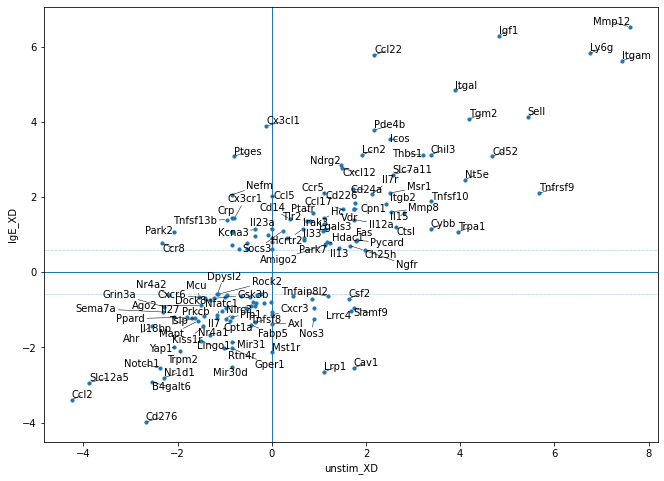

In [14]:
plot(eae_df, thresh=1.1)

# EAE Genes with Il33-like patterns

In [100]:
eae_df.loc[eae_df.index=='Il33']

,Entrez ID,F_unstim_S4,M_unstim_S2,F_IgE_S3,M_IgE_S1,log_Mi,log_Fi,log_Mu,log_Fu,unstim_XD,IgE_XD,ige_dom
Gene Symbol,,,,,,,,,,,,
Il33,77125,0.0,1.170174,693.887693,1679.757935,10.714896,9.440636,1.11781,0.0,1.11781,1.27426,1


In [101]:
def il33like(df, thresh=1):
    nthresh = -1 * thresh
    
    df1 = df.loc[((df["IgE_XD"] > thresh) & (df['unstim_XD'] > thresh)) | 
                 ((df["IgE_XD"] < nthresh) & (df['unstim_XD'] < nthresh))]
    
    print(df1.shape)
    return df1

In [102]:
il33_df = il33like(eae_df)

(62, 12)


# 3/15 venn diagrams

In [19]:
df.head()

,Gene Symbol,Entrez ID,F_unstim_S4,M_unstim_S2,F_IgE_S3,M_IgE_S1,log_Mi,log_Fi,log_Mu,log_Fu,unstim_XD,IgE_XD
0,Ccl1,20290,4.829065,4.680695,23959.367737,43864.638069,15.420804,14.548362,2.506067,2.543265,-0.037197,0.872441
1,Serpinb9b,20706,0.804844,2.340347,12956.022455,9704.409675,13.244573,13.661447,1.739998,0.851874,0.888124,-0.416873
2,Gstt1,14871,17.706573,7.021042,2446.966235,3081.395634,11.589836,11.257368,3.003790,4.225473,-1.221684,0.332468
3,Il9,16198,0.000000,0.000000,3954.312500,3016.280182,11.559033,11.949576,0.000000,0.000000,0.000000,-0.390543
4,Slco5a1,240726,15.292041,15.212258,1585.491012,1378.461013,10.429889,10.631624,4.019013,4.026095,-0.007082,-0.201735


In [ ]:
for i in ['log_Mi', 'log_Fi', 'log_Mu', 'log_Fu']:
    df['log_Mi', 'log_Fi', 'log_Mu', 'log_Fu'].loc[]

In [20]:
df.columns

Index(['Gene Symbol', 'Entrez ID', 'F_unstim_S4', 'M_unstim_S2', 'F_IgE_S3',
       'M_IgE_S1', 'log_Mi', 'log_Fi', 'log_Mu', 'log_Fu', 'unstim_XD',
       'IgE_XD'],
      dtype='object')

In [42]:
def eda(df):
    print("#genes dominant in each sample\n", df[['log_Mi', 'log_Fi', 'log_Mu', 'log_Fu']].idxmax(axis="columns").value_counts())
    
    m_up = df.loc[(df['log_Mi'] - df['log_Mu']) > 0.58].shape[0]
    f_up = df.loc[(df['log_Fi'] - df['log_Fu']) > 0.58].shape[0]
    both_up = df.loc[((df['log_Mi'] - df['log_Mu']) > 0.58) & ((df['log_Fi'] - df['log_Fu']) > 0.58)].shape[0]
    m_only_up, f_only_up = m_up-both_up, f_up-both_up
    
    m_down = df.loc[(df['log_Mi'] - df['log_Mu']) < -0.58].shape[0]
    f_down = df.loc[(df['log_Fi'] - df['log_Fu']) < -0.58].shape[0]
    both_down = df.loc[((df['log_Mi'] - df['log_Mu']) < -0.58) & ((df['log_Fi'] - df['log_Fu']) < -0.58)].shape[0]
    m_only_down, f_only_down = m_down-both_down, f_down-both_down
    
    print("\nwith IgE activation:\n")
    print("Upregulation in M only:", m_only_up)
    print("Upregulation in F only:", f_only_up)
    print("Upregulation in Both:", both_up)
    print("Upregulation total:", both_up+m_only_up+f_only_up)
    print("Downregulation in M only:", m_only_down)
    print("Downregulation in F only:", f_only_down)
    print("Downregulation in Both only:", both_down)
    print("Downregulation total:", both_down+m_only_down+f_only_down)
    
    print("\nSex differences:\n")
    
    m_f_i = df.loc[df['IgE_XD'] > 0.58].shape[0]
    m_f_u = df.loc[df['unstim_XD'] > 0.58].shape[0]
    m_f_both = df.loc[(df['IgE_XD'] > 0.58)&(df['unstim_XD'] > 0.58)].shape[0]
    mfi, mfu = m_f_i - m_f_both, m_f_u - m_f_both
    
    f_m_i = df.loc[df['IgE_XD'] < -0.58].shape[0]
    f_m_u = df.loc[df['unstim_XD'] < -0.58].shape[0]
    f_m_both = df.loc[(df['IgE_XD'] < -0.58) & (df['unstim_XD'] < -0.58)].shape[0]
    fmi, fmu = f_m_i - f_m_both, f_m_u - f_m_both
    print("M > F in IgE only:", mfi)
    print("M > F in Unstim only:", mfu)
    print("M > F in both:", m_f_both)
    print("M > F Total:", m_f_both+mfi+mfu)
    print("M < F in IgE only:", fmi)
    print("M < F in Unstim only:", fmu)
    print("M < F in both:", f_m_both)
    print("M < F Total:", f_m_both+fmi+fmu)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    
    ax1 = venn2(subsets = (m_only_up, f_only_up, both_up), set_labels = ('M', 'F'), ax=ax[0][0])
    ax[0][0].set_title("Upregulation w/ activation")
    ax2 = venn2(subsets = (m_only_down, f_only_down, both_down), set_labels = ('M', 'F'), ax=ax[0][1])
    ax[0][1].set_title("Downregulation w/ activation")
    
    ax3 = venn2(subsets = (mfi, mfu, m_f_both), set_labels = ('IgE', 'Unstim'), ax=ax[1][0])
    ax[1][0].set_title("Male dominant")
    ax4 = venn2(subsets = (fmi, fmu, f_m_both), set_labels = ('IgE', 'Unstim'), ax=ax[1][1])
    ax[1][1].set_title("Female dominant")
    plt.show();
    

#genes dominant in each sample
 log_Mi    45
log_Fi    43
log_Mu    39
log_Fu    25
dtype: int64

with IgE activation:

Upregulation in M only: 20
Upregulation in F only: 10
Upregulation in Both: 51
Upregulation total: 81
Downregulation in M only: 13
Downregulation in F only: 16
Downregulation in Both only: 33
Downregulation total: 62

Sex differences:

M > F in IgE only: 26
M > F in Unstim only: 10
M > F in both: 56
M > F Total: 92
M < F in IgE only: 28
M < F in Unstim only: 12
M < F in both: 42
M < F Total: 82


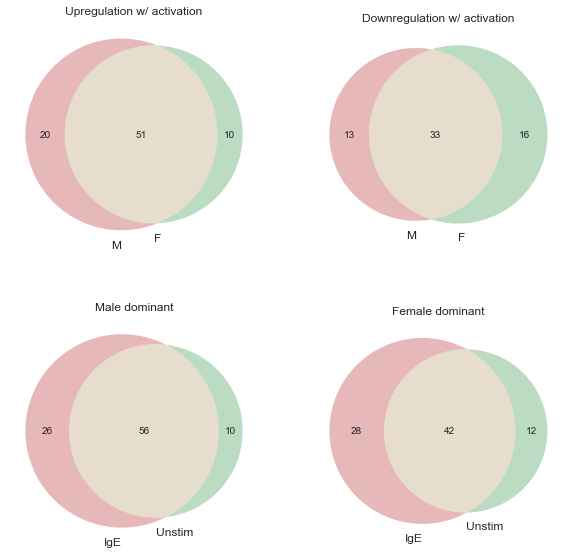

In [43]:
eda(eae_df)

In [105]:
df.shape

(15786, 12)

# Other plots 4/5/22

In [49]:
eae_df

,Gene Symbol,Entrez ID,F_unstim_S4,M_unstim_S2,F_IgE_S3,M_IgE_S1,log_Mi,log_Fi,log_Mu,log_Fu,unstim_XD,IgE_XD,IgE dominance
9,Csf2,12981,12.877508,42.126252,9607.096369,5889.085639,12.524073,13.230035,5.430494,3.794677,1.635818,-0.705962,-1
14,Ch25h,12642,0.804844,4.680695,736.255327,1202.980387,10.233596,9.526021,2.506067,0.851874,1.654193,0.707576,1
17,Il33,77125,0.000000,1.170174,693.887693,1679.757935,10.714896,9.440636,1.117810,0.000000,1.117810,1.274260,1
23,Il13,16163,156.139782,418.922170,23937.713169,37584.859717,15.197902,14.547058,8.713978,7.295905,1.418073,0.650844,1
71,Atf3,11910,0.000000,2.340347,260.796324,157.822198,7.311269,8.032301,1.739998,0.000000,1.739998,-0.721032,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15512,Tlr9,81897,0.804844,0.000000,0.000000,1.103652,1.072896,0.000000,0.000000,0.851874,-0.851874,1.072896,1
15646,Thbs1,21825,0.000000,8.191216,0.000000,7.725562,3.125248,0.000000,3.200256,0.000000,3.200256,3.125248,1
15697,Vdr,22337,0.000000,2.340347,0.000000,2.207303,1.681361,0.000000,1.739998,0.000000,1.739998,1.681361,1
15698,Cpn1,93721,0.000000,2.340347,0.000000,2.207303,1.681361,0.000000,1.739998,0.000000,1.739998,1.681361,1


In [75]:
def plot1(df, thresh=1):
    plt.figure(figsize=(10, 10))
    
    labels = []
    df1 = df.loc[(df['log_Mi'] > 2) | (df['log_Fi'] > 2)]
    for i in df1.index:
        labels.append(plt.text(x=df1['log_Mi'][i], y=df1['log_Fi'][i], s=df1["Gene Symbol"][i]))
            
    scatter = plt.scatter(data=df, s=10,  x='log_Mi', y='log_Fi')

    plt.xlabel("log_Mi")
    plt.ylabel("log_Fi")

    adjust_text(labels, force_points=0.2, force_text=0.2,
                expand_points=(1, 1), expand_text=(1, 1),
                arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))
    plt.show()
    return

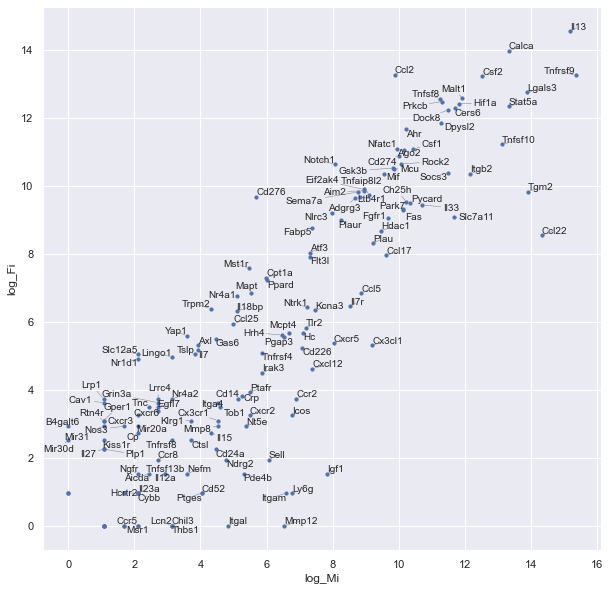

In [76]:
plot1(eae_df)

<AxesSubplot:xlabel='log_Mi', ylabel='log_Fi'>

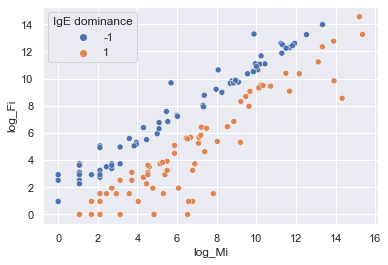

In [63]:
sns.scatterplot(data=eae_df, x='log_Mi', y='log_Fi', hue='IgE dominance', palette='deep')

<AxesSubplot:xlabel='IgE_XD', ylabel='unstim_XD'>

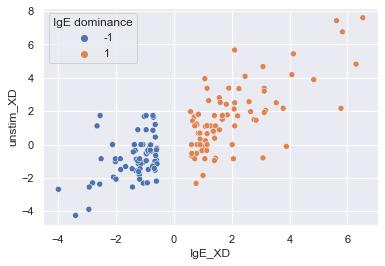

In [65]:
sns.scatterplot(data=eae_df, x='IgE_XD', y='unstim_XD', hue='IgE dominance', palette='deep')

In [ ]:
eae_df['log2 activation'] = eae_df['']

In [78]:

df.to_csv("outputs//"+'220404'+" "+"df"+".csv", index=False)
df1.to_csv("outputs//"+'220404'+" "+"df1"+".csv", index=False)
all_eae_df.to_csv("outputs//"+'220404'+" "+"all_eae_df"+".csv", index=False)
eae_df.to_csv("outputs//"+'220404'+" "+"eae_df"+".csv", index=False)